In [291]:
import pandas as pd
import os
from itertools import combinations
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#create dictionary of airport data
#import the data
demand = 'DemandGroup3.xlsx'
df1 = pd.read_excel(demand, header=None)

#clean the dataframe
df1 = df1.drop(df1.index[9:12])
df1 = df1.drop(df1.index[0:3])
df1 = df1.drop(df1.columns[0], axis=1)
#df1 = df1.reset_index()

#make a list of airport names
airport_names = df1.iloc[0, 1:].dropna().tolist()
airport_codes = df1.iloc[1,1:].tolist()
#make a list of keys 
keys = df1.iloc[1:, 0].dropna().tolist()

#create dictionaries for each airport
airport_dictionaries = {}
for i, airport in enumerate(airport_codes):
# Extract values 
    values = df1.iloc[1:,i+1].dropna().tolist()
    # Map keys to values
    airport_dictionaries[airport] = dict(zip(keys, values))

In [3]:
#add population data to airports
#import population data
population = 'pop.xlsx'
df2 = pd.read_excel(population, header=None)

#make lists of additional data
pop20 = df2.iloc[3:,1].tolist()
pop23 = df2.iloc[3:,2].tolist()
gdp20 = df2.iloc[3:,5].tolist()
gdp23 = df2.iloc[3:,6].tolist()

for i, airport in enumerate(airport_codes):
    # Map keys to values
    airport_dictionaries[airport]['pop20'] = pop20[i]
    airport_dictionaries[airport]['pop23'] = pop23[i]
    airport_dictionaries[airport]['gdp20'] = gdp20[i]
    airport_dictionaries[airport]['gdp23'] = gdp23[i]
    
airport_dictionaries['LFPG']

{'ICAO Code': 'LFPG',
 'Latitude (deg)': 49.0128,
 'Longitude (deg)': 2.55,
 'Runway (m)': 3100,
 'Available slots': 10,
 'EGLL': 967,
 'LFPG': 0,
 'EHAM': 280,
 'EDDF': 220,
 'LEMF': 142,
 'LEBL': 112,
 'EDDM': 197,
 'LIRF': 142,
 'EIDW': 142,
 'ESSA': 75,
 'LPPT': 34,
 'EDDT': 248,
 'EFHK': 51,
 'EPWA': 59,
 'EGPH': 71,
 'LROP': 17,
 'LGIR': 1,
 'BIKF': 22,
 'LICJ': 39,
 'LPMA': 11,
 'pop20': 2244000.0,
 'pop23': 2241000.0,
 'gdp20': 40638.33400426001,
 'gdp23': 38476.6586361575}

In [152]:
#make a dataset for all OD pairs to estimate an OLS regression model using 2020 data
#create a list of sets of possible pairs
pairs = list(combinations(airport_codes, 2))

#calculate demand between pairs
demands = []
for pair in range(len(pairs)):
    demands.append(airport_dictionaries[pairs[pair][0]][pairs[pair][1]])

#calculate product of population
population_product = []
for pair in range(len(pairs)):
    population_product.append(airport_dictionaries[pairs[pair][0]]['pop20']*airport_dictionaries[pairs[pair][1]]['pop20'])
    
#calculate product of GDP
gdp_product = []
for pair in range(len(pairs)):
    gdp_product.append(airport_dictionaries[pairs[pair][0]]['gdp20']*airport_dictionaries[pairs[pair][1]]['gdp20'])

print(len(population_product))

190


In [5]:
#create a function to calculate the distance between two airports using the coordinates in degrees
def calculate_distance(phi1, phi2, lamda1, lamda2):
    R_E = 6371 #km
    phi1 = np.radians(phi1)
    phi2 = np.radians(phi2)
    lamda1 = np.radians(lamda1)
    lamda2 = np.radians(lamda2)
    sigma = 2* np.arcsin(np.sqrt(np.sin((phi1 - phi2)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin((lamda1 - lamda2)/2)**2))
    d_ij = R_E * sigma
    return float(d_ij)

In [155]:
#calculate distance
distance = []
for pair in range(len(pairs)):
    distance.append(calculate_distance(airport_dictionaries[pairs[pair][0]]['Latitude (deg)'],
                                       airport_dictionaries[pairs[pair][1]]['Latitude (deg)'],
                                       airport_dictionaries[pairs[pair][0]]['Longitude (deg)'],
                                       airport_dictionaries[pairs[pair][1]]['Longitude (deg)']))
distance = np.array(distance)


In [139]:
#estimate OLS model
f = 1.42 #€/gallon fuel costs
#create dataset
ols_data = {
    'population_product': np.log(population_product),
    'gdp_product': np.log(gdp_product),
    'distance': np.log(f) + np.log(distance),
    'demand': np.log(demands) #dependent variable
}

ols_df = pd.DataFrame(ols_data)

In [140]:
# Define independent variables (X) and dependent variable (Y)
X = ols_df[['population_product', 'gdp_product', 'distance']] 
Y = ols_df['demand']  

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X, Y)

# Coefficients and intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict values
predictions = model.predict(X)
print("Predicted values:", predictions)


Intercept: -16.3862350654871
Coefficients: [ 0.58638073  0.63171159 -1.24424231]
Predicted values: [ 7.18466786  6.60962763  5.71702539  5.62860045  5.33123691  5.65847551
  5.45001298  6.12608816  4.98271261  4.02904107  6.17053776  4.40197896
  4.49359179  5.717942    3.84947441  2.80213011  3.36943321  4.31315834
  3.11970374  5.79197794  5.45885274  5.09687065  4.96459464  5.33301613
  5.06014717  4.70418476  4.19163001  3.37858907  5.57703634  3.6427828
  3.87860142  4.38387853  3.28179075  2.23315111  2.43317235  3.84645124
  2.41753752  5.21693895  4.20895754  4.01204124  4.87092346  4.36184737
  4.26634122  4.0576717   2.60069471  5.56294389  3.42217252  3.63087884
  4.21949526  2.83336005  1.69233157  2.05729     3.17709175  1.74990337
  4.05835029  3.98555471  5.67969746  4.55452734  3.62105401  3.79951693
  2.39833051  5.7425843   3.22470567  3.70315627  3.49027137  2.9076122
  1.70731395  1.66908602  3.26318227  1.54270228  5.7146549   4.38793248
  4.85892155  3.9708913   3

In [141]:
print(np.exp(model.coef_))

[1.79747109 1.88082703 0.28815916]


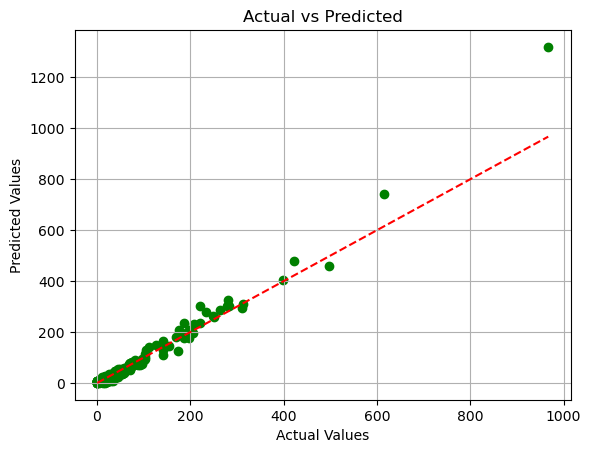

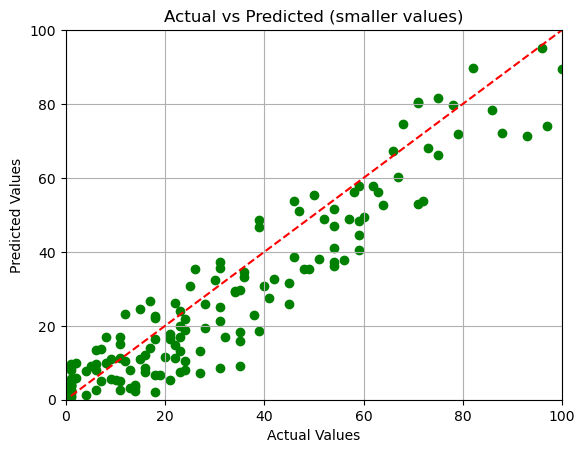

In [142]:
#plot actual agains predicted values

# Sample data
actual = demands
predicted = np.exp(predictions)

# Scatter plot for all values
plt.figure()
plt.scatter(actual, predicted, color='green')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.title('Actual vs Predicted')
plt.show()

# Scatter plot zoomed in on the smaller values
plt.figure()
plt.scatter(actual, predicted, color='green')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.title('Actual vs Predicted (smaller values)')
plt.show()

In [143]:
#calculate the values for population and gdp for 2025
annual_growth_pop = (np.array(pop23) - np.array(pop20))/3
pop25 = np.array(pop23) + 2*annual_growth_pop

annual_growth_gdp = (np.array(gdp23) - np.array(gdp20))/3
gdp25 = np.array(gdp23) + 2*annual_growth_gdp

#add to dictionaries
for i, airport in enumerate(airport_codes):
    # Map keys to values
    airport_dictionaries[airport]['pop25'] = pop25[i]
    airport_dictionaries[airport]['gdp25'] = gdp25[i]

In [144]:
#calculate product of population
population_product25 = []
for pair in range(len(pairs)):
    population_product25.append(airport_dictionaries[pairs[pair][0]]['pop25']*airport_dictionaries[pairs[pair][1]]['pop25'])
    
#calculate product of GDP
gdp_product25 = []
for pair in range(len(pairs)):
    gdp_product25.append(airport_dictionaries[pairs[pair][0]]['gdp25']*airport_dictionaries[pairs[pair][1]]['gdp25'])



In [145]:
ols_data_25 = pd.DataFrame({
    'population_product': np.log(population_product25),
    'gdp_product': np.log(gdp_product25),
    'distance': np.log(f*distance),
})
predictions2025 = model.predict(ols_data_25)
predictions2025 = np.exp(predictions2025)
print("Predicted Values:", predictions2025)

Predicted Values: [1.36130328e+03 8.51547280e+02 3.78998523e+02 2.73341598e+02
 2.03939264e+02 3.61190288e+02 2.34975389e+02 7.66559966e+02
 1.75289870e+02 6.15152310e+01 6.03240164e+02 9.48364009e+01
 1.09186092e+02 3.47738202e+02 6.36207286e+01 1.26886572e+01
 5.33162102e+01 7.41460437e+01 2.22013031e+01 3.23102955e+02
 2.51621342e+02 1.38042026e+02 1.21479514e+02 2.24193886e+02
 1.36753584e+02 1.58947700e+02 6.83009784e+01 2.75884855e+01
 2.86397200e+02 3.81498889e+01 5.07356595e+01 7.87243193e+01
 3.09948594e+01 6.17368030e+00 1.79671527e+01 3.99606532e+01
 9.45506384e+00 2.19622240e+02 6.31518724e+01 5.20960784e+01
 1.57011022e+02 7.56243478e+01 1.14049106e+02 6.64110340e+01
 1.40891016e+01 3.13934588e+02 3.40152856e+01 4.40270347e+01
 7.42521169e+01 2.20054050e+01 3.99631643e+00 1.37159629e+01
 2.27469993e+01 5.39144662e+00 5.90281691e+01 5.51293734e+01
 3.83051532e+02 9.96374190e+01 6.50022199e+01 5.57450135e+01
 1.25048540e+01 4.08260145e+02 3.03386558e+01 5.14268709e+01
 3.891

In [146]:
#make a dictionary mapping the distances to the pairs
pair_distances = dict(zip(pairs, distance))

#make a dictionary mapping the demand to the pair
pair_demands = dict(zip(pairs, predictions2025))

In [161]:
#make a matrix of all airports
distance_airport_matrix = np.zeros((20, 20))

# calculate the distance of the pairs
for a1, a2 in pairs:    
    i, j = airport_codes.index(a1), airport_codes.index(a2)
    distance_airport_matrix[i, j] = pair_distances[(a1,a2)]  # Mark connection
    distance_airport_matrix[j, i] = pair_distances[(a1,a2)]  # Since connections are bidirectional

#Convert to Pandas DataFrame for better readability
df_airport_matrix = pd.DataFrame(distance_airport_matrix, index=airport_codes, columns=airport_codes)

# Display the matrix
print(df_airport_matrix)

             EGLL         LFPG         EHAM         EDDF         LEMF  \
EGLL     0.000000   347.167287   370.449402   654.763633  1245.952548   
LFPG   347.167287     0.000000   398.269751   449.005069  1064.514288   
EHAM   370.449402   398.269751     0.000000   366.577487  1460.655483   
EDDF   654.763633   449.005069   366.577487     0.000000  1422.050572   
LEMF  1245.952548  1064.514288  1460.655483  1422.050572     0.000000   
LEBL  1147.713365   858.738099  1241.135764  1093.611403   482.930856   
EDDM   941.580243   681.569293   664.165829   299.073649  1496.969380   
LIRF  1443.885736  1100.692840  1296.818437   958.129716  1329.628631   
EIDW   449.255644   784.969337   750.162256  1086.894020  1454.225119   
ESSA  1462.537956  1539.155518  1152.168259  1222.987175  2601.349371   
LPPT  1563.929977  1469.963286  1846.296630  1873.847060   512.884558   
EDDT   947.244457   850.497497   578.186655   431.682624  1853.640993   
EFHK  1847.955566  1895.558234  1521.303368  1537.9

In [284]:
from gurobipy import *

# Data
Airports = airport_codes #list of airports
airports = range(len(Airports)) #number of airports
d = distance_airport_matrix #distance between airports
c_x = [300, 600, 1250, 2000] #fixed costs per aircraft
c_t = [750, 775, 1400, 2800] #time based costs /h
c_f = [1, 2, 3.75, 9] #fuel cost parameter
s = [45, 70, 150, 320] #seats
V = [550, 820, 850, 870] #speed
aircraft = [1, 2, 3, 4] #set of aircraft
CASK = np.zeros((20,20,4)) #empty array for CASK
#calculate CASK for each aircraft and each OD-pair
for k in range(len(aircraft)):
    for i in airports:
        for j in airports:
            if i != j:
                CASK[i][j][k] = (((c_x[k]) + (c_t[k]*d[i][j]/V[k]) + (c_f[k]*f*d[i][j])/1.5)/(d[i][j]*s[k]))

#flights departing or arriving at hub madrid have lower costs
for k in range(len(aircraft)):
    for i in airports:
        for j in airports:
            if i != j:
                if i == 4 or j == 4:
                    CASK[i][j][k] = 0.7 * CASK[i][j][k]
LF = 0.75 #load factor            
a = np.zeros((20,20,4))


In [287]:

TAT = [25/60, 35/60, 45/60, 60/60] # turnaround time

BT = 10 * 7  #hours per day
r = [1500, 3300, 6300, 12000] #max range in km of aircraft

y = np.zeros((20,20)) #yield per od pair
for i in airports:
    for j in airports:
        if i !=j:
            y[i][j] = 5.9 * d[i][j]**-0.76 + 0.043 
#make a matrix for the demand    
demand_airport_matrix = np.zeros((20, 20))

# calculate the demands of the pairs
for a1, a2 in pairs:    
    i, j = airport_codes.index(a1), airport_codes.index(a2)
    demand_airport_matrix[i, j] = pair_demands[(a1,a2)] 
    demand_airport_matrix[j, i] = pair_demands[(a1,a2)]  
#Convert to Pandas DataFrame for better readability
df_demand_matrix = pd.DataFrame(demand_airport_matrix, index=airport_codes, columns=airport_codes)
q = demand_airport_matrix

g = np.ones(20) #initialize array for hub parameter
g[4] = 0 #madrid is our hub
c = [15000, 34000, 80000, 190000] #weekly leasing costs

#runway length airports
r_length = np.zeros(20)
for i in airport_codes:
    r_length[airport_codes.index(i)] = airport_dictionaries[i]['Runway (m)']
#required runway
rr = [1400, 1600, 1800, 2600]

#airport slots
slots= np.zeros(20)
for i in airport_codes:
    if i != 'LEMF':
        slots[airport_codes.index(i)] = airport_dictionaries[i]['Available slots']
        

In [321]:
# Start modelling optimization problem
m = Model('fleet_network')
x = {} #direct flow between airports i and j
z = {} #number of flights between airports i and j
w = {} #flow transferring at hub
ac = {} #number of aircraft
N = range(len(airport_codes))
K = range(len(aircraft))
# Initialize variables
for i in N:
    for j in N:
        if i != j:  # Exclude self-loops
            x[i, j] = m.addVar(obj=y[i][j] * d[i][j], lb=0, vtype=GRB.CONTINUOUS, name=f"x_{i}_{j}")
            w[i, j] = m.addVar(obj=y[i][j] * d[i][j], lb=0, vtype=GRB.CONTINUOUS, name=f"w_{i}_{j}")

for i in N:
    for j in N:
        for k in K:
            if i != j:  
                z[i, j, k] = m.addVar(
                    obj = -CASK[i][j][k], lb=0, vtype=GRB.INTEGER, name=f"z_{i}_{j}_{k}"
                )

for k in K:
    ac[k] = m.addVar(obj = -c[k], lb=0, vtype=GRB.INTEGER, name=f"ac_{k}")

m.update()
m.setObjective(m.getObjective(), GRB.MAXIMIZE)   # The objective is to maximize profit

# Add constraints
for i in N:
    for j in N:
        if i != j:
            # C1a
            m.addConstr(x[i, j] + w[i, j] <= q[i][j])
            
            # C1b
            m.addConstr(w[i, j] <= q[i][j] * g[i] * g[j])
            
            # C2
            m.addConstr(
                x[i, j]
                + quicksum(w[i, m] * (1 - g[j]) for m in I if (i, m) in w)
                + quicksum(w[m, j] * (1 - g[j]) for m in I if (m, j) in w)
                <= quicksum(z[i, j, k] * s[k] * LF for k in K if (i, j, k) in z)
            )
#C3        
for i in N:
    for k in K:
        m.addConstr(quicksum(z[i, j, k] for j in J if (i, j, k) in z)
                    - quicksum(z[j, i, k] for j in J if (j, i, k) in z) == 0)
       
   
for k in K:
    m.addConstr(quicksum(quicksum((d[i][j] / V[k] + (TAT[k] * 1.5 * (1-g[j]) + TAT[k] * (g[j])))* z[i, j, k] 
                 for i in I if (i, j, k) in z) for j in J if (i, j, k) in z)
        <= BT * ac[k]) #C4
    
for i in N:
    for j in N: 
        for k in range(len(aircraft)):
            if d[i][j] <= r[k]:
                a[i][j][k] = 10000               
            if rr[k] <= r_length[i] or rr[k] <= r_length[j]:
                a[i][j][k] = 10000
            else:
                 a[i][j][k] = 0

                    
                    
                    
for i in N:
    for j in N: 
        for k in K:
            if i != j:
                m.addConstr(z[i,j,k] <= a[i][j][k])  #C5



#for i in I:
#    for j in J:
#        if i!=j :
#            if i != 4 and j != 4:
#                m.addConstr(quicksum(z[i,j,k] for i in I if (i, j, k) in z) <=  slots[i])
m.update()
m.write('test.lp')
# Set time constraint for optimization (5minutes)
# m.setParam('TimeLimit', 1 * 60)
# m.setParam('MIPgap', 0.009)
m.optimize()
# m.write("testout.sol")
status = m.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = m.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)


# Print out Solutions
print()
print("Frequencies:----------------------------------")
print()
for i in airports:
    for j in airports:
        for k in range(4):
            if i != j:
                if z[i,j,k].X >0:
                    print(airport_names[i], ' to ', airport_names[j], 'with type ', aircraft[k], z[i, j, k].X)
                    print(w[i,j])

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2744 rows, 2284 columns and 9751 nonzeros
Model fingerprint: 0x6f3d3225
Variable types: 760 continuous, 1524 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-01, 2e+02]
  Objective range  [3e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 1938 rows and 80 columns
Presolve time: 0.05s
Presolved: 806 rows, 2204 columns, 7246 nonzeros
Variable types: 715 continuous, 1489 integer (7 binary)

Root relaxation: objective 1.238820e+06, 1619 iterations, 0.16 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

 458524 206976 1217301.73   58   54 1217205.89 1217592.85  0.03%  14.0  315s
 464174 209651 1217410.46   68   48 1217205.89 1217591.61  0.03%  14.0  320s
 471513 213330 1217424.12   61   48 1217205.89 1217589.78  0.03%  14.0  325s
 479138 217032 1217459.30   47   55 1217205.89 1217588.11  0.03%  14.0  331s
 484898 219658 1217382.44   50   74 1217205.89 1217586.66  0.03%  14.0  335s
 491085 222426 1217287.48   41   81 1217205.89 1217585.50  0.03%  14.0  341s
 498697 225955 1217385.17   52   75 1217205.89 1217583.69  0.03%  14.0  346s
 504515 228805 1217311.48   65   37 1217205.89 1217582.53  0.03%  14.0  350s
 512134 232498     cutoff   47      1217205.89 1217580.89  0.03%  14.0  355s
 519618 236209 1217394.78   59   55 1217205.89 1217579.28  0.03%  14.0  360s
 525347 238758 1217342.00   47   44 1217205.89 1217578.20  0.03%  14.0  365s
 532779 241648 1217433.01   47   71 1217205.89 1217576.78  0.03%  14.0  371s
 537075 244359 1217488.97   67   37 1217205.89 1217575.83  0.03%  14.0  375s

 1051541 256456 1217342.81   58   40 1217317.64 1217504.17  0.02%  14.1  836s
 1055346 257327 1217369.15   54   58 1217317.64 1217503.48  0.02%  14.1  841s
 1059467 258245 1217348.58   64   55 1217317.64 1217502.80  0.02%  14.1  846s
 1063312 259089 1217442.02   45   63 1217317.64 1217502.19  0.02%  14.1  850s
 1068699 260188     cutoff   52      1217317.64 1217501.39  0.02%  14.1  855s
 1074388 261277 1217434.62   66   43 1217317.64 1217500.52  0.02%  14.1  861s
 1078087 261941 1217363.37  126   40 1217317.64 1217499.96  0.01%  14.1  866s
 1081795 262552 1217351.46   64   34 1217317.64 1217499.40  0.01%  14.1  870s
 1087123 263413 1217434.12   49   47 1217317.64 1217498.51  0.01%  14.1  876s
 1090866 264287 1217347.65   50   52 1217317.64 1217498.03  0.01%  14.1  881s
 1094729 265102 1217399.90   56   61 1217317.64 1217497.52  0.01%  14.1  887s
 1096697 265433 1217360.01   73   41 1217317.64 1217497.22  0.01%  14.1  891s
 1100444 266000 1217325.98   53   64 1217317.64 1217496.72  0.01

Rome  to  Madrid with type  1 5.0
<gurobi.Var w_7_4 (value 0.0)>
Rome  to  Barcelona with type  1 4.0
<gurobi.Var w_7_5 (value 0.0)>
Rome  to  Munich with type  1 6.0
<gurobi.Var w_7_6 (value 6.953272585304148)>
Rome  to  Dublin with type  2 1.0
<gurobi.Var w_7_8 (value 1.8193803103525497)>
Rome  to  Stockholm with type  2 1.0
<gurobi.Var w_7_9 (value 0.0)>
Rome  to  Berlin with type  1 4.0
<gurobi.Var w_7_11 (value 2.454825787777281)>
Rome  to  Berlin with type  2 1.0
<gurobi.Var w_7_11 (value 2.454825787777281)>
Rome  to  Helsinki with type  1 1.0
<gurobi.Var w_7_12 (value 0.0)>
Rome  to  Warsaw with type  2 1.0
<gurobi.Var w_7_13 (value 0.0)>
Rome  to  Edinburgh with type  1 1.0
<gurobi.Var w_7_14 (value 0.0)>
Rome  to  Bucharest with type  1 2.0
<gurobi.Var w_7_15 (value 0.0)>
Rome  to  Heraklion with type  1 1.0
<gurobi.Var w_7_16 (value 0.0)>
Rome  to  Palermo with type  1 6.0
<gurobi.Var w_7_18 (value 0.0)>
Dublin  to  London with type  1 23.0
<gurobi.Var w_8_0 (value 0.0)>
Dubl

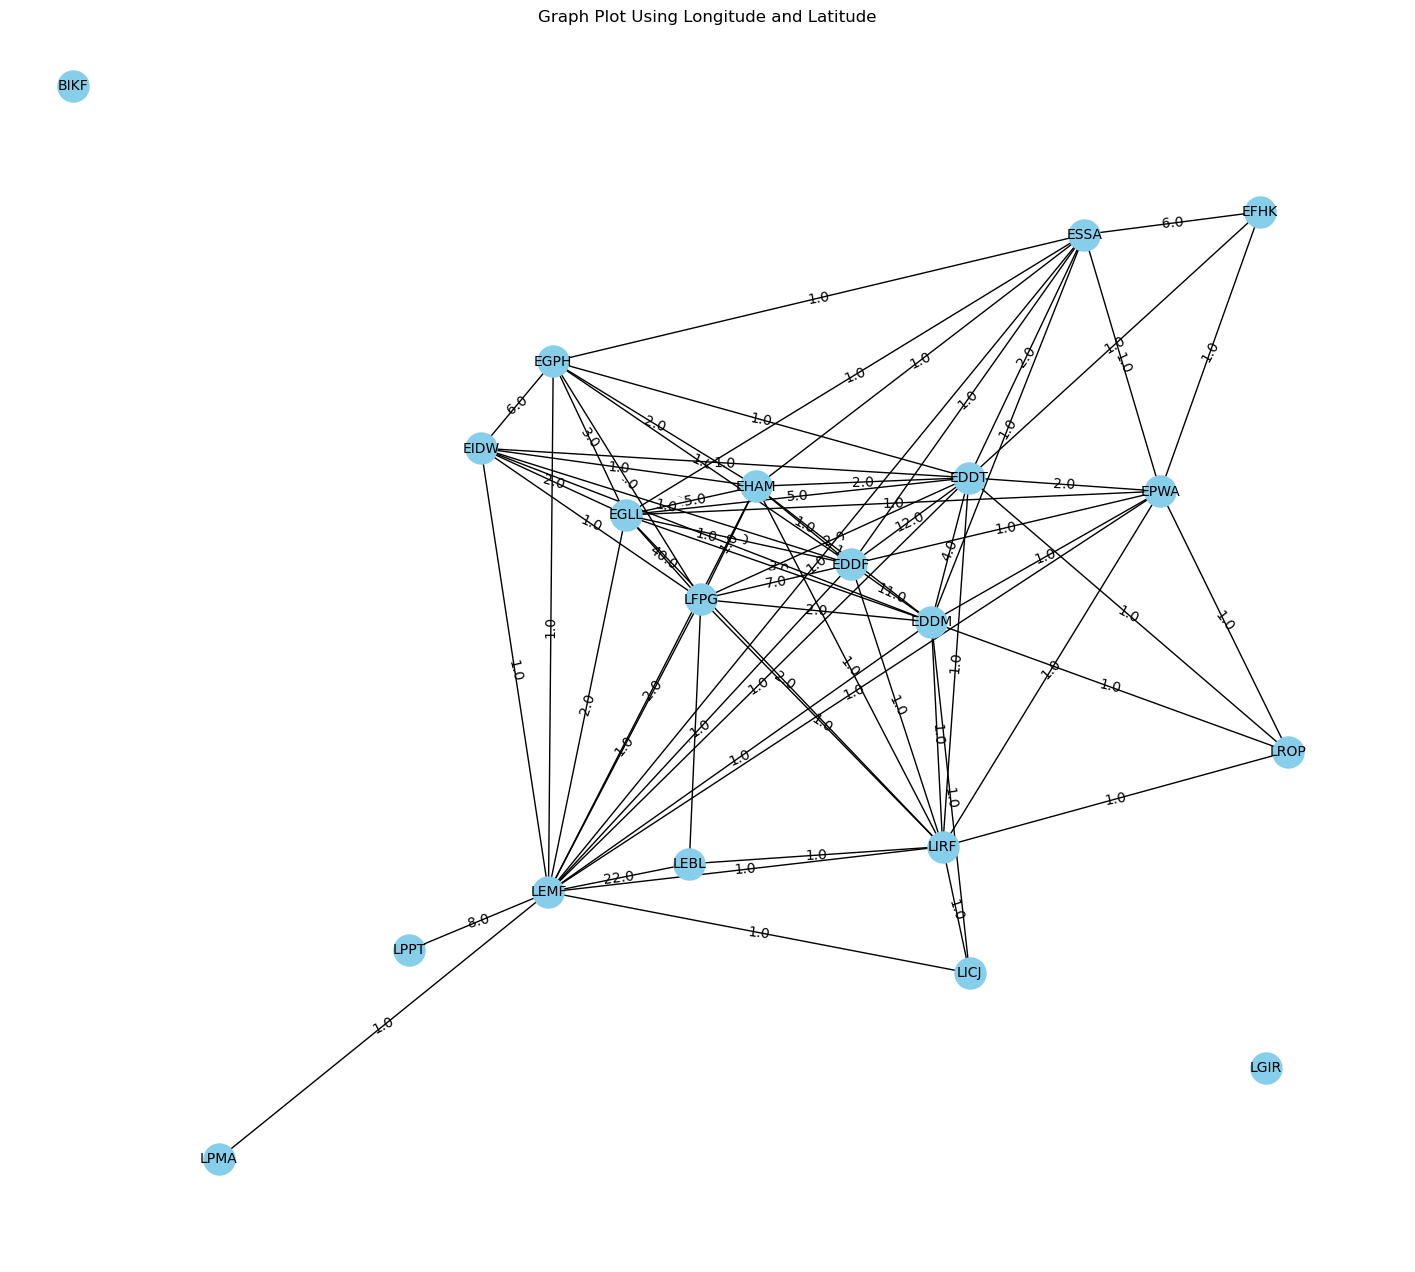

In [320]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

for airport in airport_codes:
    airport_dictionaries[airport]['coordinates'] = (airport_dictionaries[airport]['Longitude (deg)'], 
                                                  airport_dictionaries[airport]['Latitude (deg)'])
    G.add_node(airport, pos = airport_dictionaries[airport]['coordinates'])
# Example edges
#edges = [("A", "B"), ("B", "C"), ("C", "D"), ("A", "D")]

for i in N:
    for j in N:
        for k in K:
            if i != j:
                if z[i,j,k].X > 0:
                    G.add_edge(airport_codes[i], airport_codes[j], weight = z[i,j,k].X)



# Add edges
#G.add_edges_from(edges)

# Extract positions for plotting
positions = nx.get_node_attributes(G, 'pos')

# Plot the graph
plt.figure(figsize=(18, 16))
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, font_size=10)
nx.draw(G, pos=positions, with_labels=True, node_size=500, node_color="skyblue", font_size=10)
plt.title("Graph Plot Using Longitude and Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [299]:
airport_dictionaries

{'EGLL': {'ICAO Code': 'EGLL',
  'Latitude (deg)': 51.4706,
  'Longitude (deg)': -0.46194,
  'Runway (m)': 3200,
  'Available slots': 8,
  'EGLL': 0,
  'LFPG': 967,
  'EHAM': 615,
  'EDDF': 279,
  'LEMF': 234,
  'LEBL': 175,
  'EDDM': 264,
  'LIRF': 209,
  'EIDW': 498,
  'ESSA': 155,
  'LPPT': 63,
  'EDDT': 422,
  'EFHK': 75,
  'EPWA': 100,
  'EGPH': 283,
  'LROP': 54,
  'LGIR': 21,
  'BIKF': 34,
  'LICJ': 68,
  'LPMA': 18,
  'pop20': 8136000.0,
  'pop23': 8750000.0,
  'gdp20': 38893.01849373653,
  'gdp23': 39720.44342678359,
  'pop25': 9159333.333333334,
  'gdp25': 40272.060048814965,
  'coordinates': (51.4706, -0.46194)},
 'LFPG': {'ICAO Code': 'LFPG',
  'Latitude (deg)': 49.0128,
  'Longitude (deg)': 2.55,
  'Runway (m)': 3100,
  'Available slots': 10,
  'EGLL': 967,
  'LFPG': 0,
  'EHAM': 280,
  'EDDF': 220,
  'LEMF': 142,
  'LEBL': 112,
  'EDDM': 197,
  'LIRF': 142,
  'EIDW': 142,
  'ESSA': 75,
  'LPPT': 34,
  'EDDT': 248,
  'EFHK': 51,
  'EPWA': 59,
  'EGPH': 71,
  'LROP': 17,
  